# Testing for E1 - COGNITION
fistly define the UUID of the experiment to use

In [63]:
experimentId="fd822eaf-4e73-47b6-9961-3e9cc82e6c82"

-------------------------------------------------------

In [64]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load cognition

In [65]:
samplerate=200  #Should rethink this

In [66]:
annotations, signalsMetadata = loadCOGNITIONSpindles(cognipath)

In [67]:
annotations.head()

,subjectId,channel,startTime,stopTime,duration,phase,labelerId,type,samplerate,startInd,stopInd
0,0001,C3,1938.132297,1939.202326,1.070029,2,0001,spindle,200,387626,387840
1,0001,C3,2047.217898,2048.112834,0.894936,2,0001,spindle,200,409444,409623
2,0001,C3,2170.856032,2171.634237,0.778205,3,0001,spindle,200,434171,434327
3,0001,C3,2219.766538,2220.894943,1.128405,3,0001,spindle,200,443953,444179
4,0001,C3,2263.482492,2264.357974,0.875482,3,0001,spindle,200,452696,452872


In [68]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION


## Load experiment results

In [69]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [70]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,modelId,spindleTimeRate
0,0001,E1,[0001],"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...",a9bee25f-2854-45ae-8574-e9f2c01f11cc,0.008159


In [71]:
#we show the difference in class inbalance for the annotation criteria considered
experimentModels[['criteriumName','spindleTimeRate']].groupby('criteriumName').describe()

spindleTimeRate                                              \
                        count      mean std       min       25%       50%   
criteriumName                                                               
E1                        1.0  0.008159 NaN  0.008159  0.008159  0.008159   

                                   
                    75%       max  
criteriumName                      
E1             0.008159  0.008159

In [72]:
featureSelection

,window,characteristic,bandName,score
0,2,hjortActivity,beta2,69.0
1,1,hjortActivity,sigma,63.0
2,2,hjortActivity,beta1,42.0
3,2,hjortActivity,delta2,41.0
4,1.5,sigmaIndex,broadband,39.0
5,2,sigmaIndex,broadband,39.0
6,2,hjortActivity,theta,38.0
7,2,hjortMobility,beta1,37.0
8,2,hjortActivity,alpha,35.0
9,1,sigmaIndex,broadband,34.0


## Hyperparameter definition
this should come from a previous evaluation notebook

In [73]:
hyperClose=0.1
hyperDuration=0.3
hyperThres=0.4
hyperDepth=10

## Testing with E1 criterium
we test the optimal points for the prediction threshold and number of boost iterations in the different validation groups

In [74]:
experimentModels=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)
experimentModels

,criteriumId,criteriumName,labelerIdList,train,modelId,spindleTimeRate
0,0001,E1,[0001],"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...",a9bee25f-2854-45ae-8574-e9f2c01f11cc,0.008159


In [75]:
autoAnnotations=pd.DataFrame()

In [76]:
rawF1s=[]
rawPrecisions=[]
rawRecalls=[]

f1s=[]
precisions=[]
recalls=[]

eventF1s=[]
eventPrecisions=[]
eventRecalls=[]

checks=[]

for ind,row in experimentModels.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    for testSubjectId in signalsMetadata.subjectId:
        print(testSubjectId)
        
        #Define annotations criterium
        usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
        #Load features and labels
        testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
        testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

        #Predict
        testDMatrix=xgb.DMatrix(data=testFeatures)
        probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
        rawLabels=probabilities>=hyperThres
        #Raw Metrics
        rawTp=np.sum(rawLabels*testLabels)
        rawFp=np.sum(rawLabels*(1-testLabels))
        rawTn=np.sum((1-rawLabels)*(1-testLabels))
        rawFn=np.sum((1-rawLabels)*testLabels)
        #Raw appends
        rawF1s.append(2*rawTp/(2*rawTp+rawFp+rawFn))
        rawPrecisions.append(rawTp/(rawTp+rawFp) )
        rawRecalls.append(rawTp/(rawTp+rawFn))
        #Process
        processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)
        #Processed metrics
        tp=np.sum(processedLabels*testLabels)
        fp=np.sum(processedLabels*(1-testLabels))
        tn=np.sum((1-processedLabels)*(1-testLabels))
        fn=np.sum((1-processedLabels)*testLabels)
        #Processed appends
        f1s.append(2*tp/(2*tp+fp+fn))
        precisions.append(tp/(tp+fp))
        recalls.append(tp/(tp+fn))

        #By-event metrics
        processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
        gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
        f,r,p=annotationPairToMetrics(gtAnnotations,processedAnnotations)
        
        #calculate metrics
        eventF1s.append(f)
        eventPrecisions.append(p)
        eventRecalls.append(r)

        #append to data frame
        processedAnnotations['subjectId']=testSubjectId
        autoAnnotations=pd.concat((autoAnnotations,processedAnnotations))


*************************
1 of 1
0001
0002
0003
0004
0005
0006
0007
0008
0009


In [88]:
autoAnnotations['samplerate']=200

In [89]:
autoAnnotations

,startInd,stopInd,duration,subjectId,samplerate
0,460434,460613,0.895,0001,200
1,495074,495185,0.555,0001,200
2,1304348,1304452,0.520,0001,200
3,1313575,1313642,0.335,0001,200
4,1438524,1438648,0.620,0001,200
...,...,...,...,...,...
57,7122898,7123051,0.765,0009,200
58,7857459,7857554,0.475,0009,200
59,7876345,7876655,1.550,0009,200
60,7880401,7880527,0.630,0009,200


### Saving visualizations

In [86]:
signals, _, _ = loadCOGNITIONSpindles(cognipath,returnSignals=True)

In [87]:
def saveSpindleFreqsGraphII(row,signals,freqRange,fftResolution=2048,folder="./characteristicFreqsImagesII"):
    if not os.path.isdir(folder):
        os.mkdir(folder)

    fig = sb.make_subplots(rows=2, cols=1, row_heights=[0.3, 0.7],specs=[[{}],[{"secondary_y": True}]])

    signal=signals[row.subjectId]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/row.samplerate)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]
    #timepoints
    timepoints=np.arange(len(signal))/row.samplerate

    #upper plot
    graphPoints=seconds2index(5,row.samplerate)
    segmentPoints=row.stopInd-row.startInd
    auxStart=int(row.startInd-(graphPoints-segmentPoints)/2)
    auxStop=auxStart+graphPoints
    fig.add_trace(go.Scatter(x=timepoints[auxStart:auxStop]-timepoints[row.startInd], y=signals[row.subjectId][auxStart:auxStop]),
                row=1, col=1)
    fig.data[-1].name = '5 seconds of signal'
    fig.add_vline(x=0,line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.add_vline(x=timepoints[row.stopInd]-timepoints[row.startInd],line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.update_xaxes(title_text="time from spindle start / s",
                row=1, col=1)

    #lower plot
    fig.add_trace(go.Line(x=freq[roi],y=PSDSegment),
                row=2, col=1,secondary_y=False)
    fig.data[-1].name = 'PSD'
    fig.update_yaxes(rangemode="nonnegative",
                row=2, col=1,secondary_y=False)
    fig.add_trace(go.Line(x=freq[roi],y=np.cumsum(PSDSegment), fill='tozeroy',fillcolor='rgba(180,0,0,0.2)', mode='lines' ,line=dict(dash='dot',color='rgba(180,0,0,0.2)')),
                row=2, col=1,secondary_y=True)
    fig.data[-1].name = 'cummulative sum'
    fig.add_vline(x=medianFreq,line=dict(dash='dot',color='green'),
                row=2, col=1)
    fig.add_vline(x=peakFreq,line=dict(dash='dash',color='yellow'),
                row=2, col=1)
    fig.add_hline(y=0.5,line=dict(dash='dot',color='rgba(30,30,30,0.6)'),
                row=2, col=1,secondary_y=True)

    fig.update_yaxes(title_text="<b>PSD</b>",
                row=2, col=1, secondary_y=False)
    fig.update_yaxes(title_text="cummulative sum",
                row=2, col=1, secondary_y=True)
    fig.update_xaxes(title_text="<b>frequency / Hz<b>",
                row=2, col=1)

    plotly.io.write_image(fig,folder+"/"+row.subjectId+"_"+str(row.name).zfill(4)+"_spindle_visual_test.png")

In [90]:
freqRoi=[8,16]
#uncomment and run if you don't have the images, check under in your project folder (should take less than 5 mins)
aux=autoAnnotations.apply(lambda x: 
    saveSpindleFreqsGraphII(x,signals,freqRoi,folder=cognipath+"/graphical/automaticPSD")
    ,axis=1)

del aux

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Extracting descriptors

In [91]:
def getMedianFreq(row,signals,freqRange,fftResolution=2048):
    signal=signals[row.subjectId]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/row.samplerate)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    #peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]
    return medianFreq

In [93]:
autoAnnotations['medianFreq']=autoAnnotations.apply(lambda row: getMedianFreq(row,signals,freqRoi),axis=1)

In [98]:
descriptors=autoAnnotations.groupby('subjectId',as_index=False).mean()

In [103]:
descriptors=descriptors[['duration','medianFreq','subjectId']]
descriptors

,duration,medianFreq,subjectId
0,0.877903,11.606603,0001
1,0.959410,12.847559,0002
2,1.117133,11.815871,0003
3,0.950774,12.120394,0004
4,0.867112,12.436139,0005
5,0.781475,13.101238,0006
6,0.744033,12.289580,0007
7,0.649474,12.332956,0008
8,0.752903,10.983178,0009


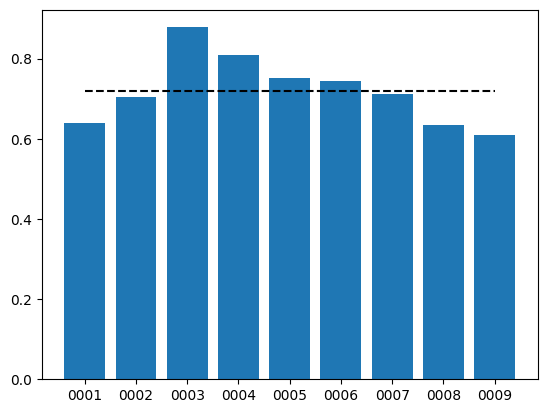

In [78]:
plt.bar(signalsMetadata.subjectId,eventF1s)
plt.hlines(np.mean(eventF1s),0,8, color='k',linestyles='--')

In [105]:
densityDf=autoAnnotations.groupby('subjectId',as_index=False).count()
densityDf['count']=densityDf['duration']
densityDf=densityDf[['subjectId','count']]
descriptors=pd.merge(descriptors,densityDf)

In [107]:
descriptors

,duration,medianFreq,subjectId,count
0,0.877903,11.606603,0001,155
1,0.959410,12.847559,0002,161
2,1.117133,11.815871,0003,912
3,0.950774,12.120394,0004,452
4,0.867112,12.436139,0005,445
5,0.781475,13.101238,0006,217
6,0.744033,12.289580,0007,362
7,0.649474,12.332956,0008,38
8,0.752903,10.983178,0009,62


In [80]:
testCognitivos=pd.read_csv(cognipath+'/testCognitivos_9.csv')
testCognitivos['subjectId']=testCognitivos.apply(lambda row: str(row.subjectId).zfill(4),axis=1)
testCognitivos

,subjectId,Codigo,Edad,Peso,Talla,IMC,Fecha_PSG,IAH,Chervin,Chervin_SAHS,BAS-II,PPVT-III,ENFEN - F1,ENFEN - F2,ENFEN - S1,ENFEN - S2,ENFEN - A,ENFEN - I
0,0001,COG001,6.7,28.0,124,18.2,28/01/2020,28.4,18,1,87,100,6,3,4,1,2,5
1,0002,COG002,7.3,31.0,130,18.3,04/02/2020,25.2,6,0,121,98,5,9,6,8,5,7
2,0003,COG003,8.7,40.5,132,23.2,25/02/2020,3.0,15,1,87,103,7,3,3,7,6,7
3,0004,COG004,8.1,36.0,138,18.9,26/02/2020,1.6,7,0,102,108,4,7,5,6,4,4
4,0005,COG005,9.6,33.8,138,17.7,04/03/2020,6.6,5,0,55,89,1,5,7,5,2,6
5,0006,COG006,7.6,28.0,125,17.9,05/03/2020,10.9,9,1,109,96,5,8,7,5,4,10
6,0007,COG007,7.5,32.0,135,17.6,10/03/2020,3.0,15,1,95,101,3,6,3,1,3,7
7,0008,COG008,6.4,17.0,113,13.3,11/03/2020,3.7,11,1,109,112,6,5,8,5,3,7
8,0009,COG009,6.6,23.0,127,14.3,12/03/2020,27.4,15,1,98,107,5,5,6,1,5,7


In [109]:
descriptors=pd.merge(descriptors,testCognitivos,on='subjectId')

In [110]:
descriptors

,duration,medianFreq,subjectId,count,Codigo,Edad,Peso,Talla,IMC,Fecha_PSG,...,Chervin,Chervin_SAHS,BAS-II,PPVT-III,ENFEN - F1,ENFEN - F2,ENFEN - S1,ENFEN - S2,ENFEN - A,ENFEN - I
0,0.877903,11.606603,0001,155,COG001,6.7,28.0,124,18.2,28/01/2020,...,18,1,87,100,6,3,4,1,2,5
1,0.959410,12.847559,0002,161,COG002,7.3,31.0,130,18.3,04/02/2020,...,6,0,121,98,5,9,6,8,5,7
2,1.117133,11.815871,0003,912,COG003,8.7,40.5,132,23.2,25/02/2020,...,15,1,87,103,7,3,3,7,6,7
3,0.950774,12.120394,0004,452,COG004,8.1,36.0,138,18.9,26/02/2020,...,7,0,102,108,4,7,5,6,4,4
4,0.867112,12.436139,0005,445,COG005,9.6,33.8,138,17.7,04/03/2020,...,5,0,55,89,1,5,7,5,2,6
5,0.781475,13.101238,0006,217,COG006,7.6,28.0,125,17.9,05/03/2020,...,9,1,109,96,5,8,7,5,4,10
6,0.744033,12.289580,0007,362,COG007,7.5,32.0,135,17.6,10/03/2020,...,15,1,95,101,3,6,3,1,3,7
7,0.649474,12.332956,0008,38,COG008,6.4,17.0,113,13.3,11/03/2020,...,11,1,109,112,6,5,8,5,3,7
8,0.752903,10.983178,0009,62,COG009,6.6,23.0,127,14.3,12/03/2020,...,15,1,98,107,5,5,6,1,5,7


C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_9684\1804215650.py:9: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_9684\1804215650.py:10: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Spearman Correlation p-values')

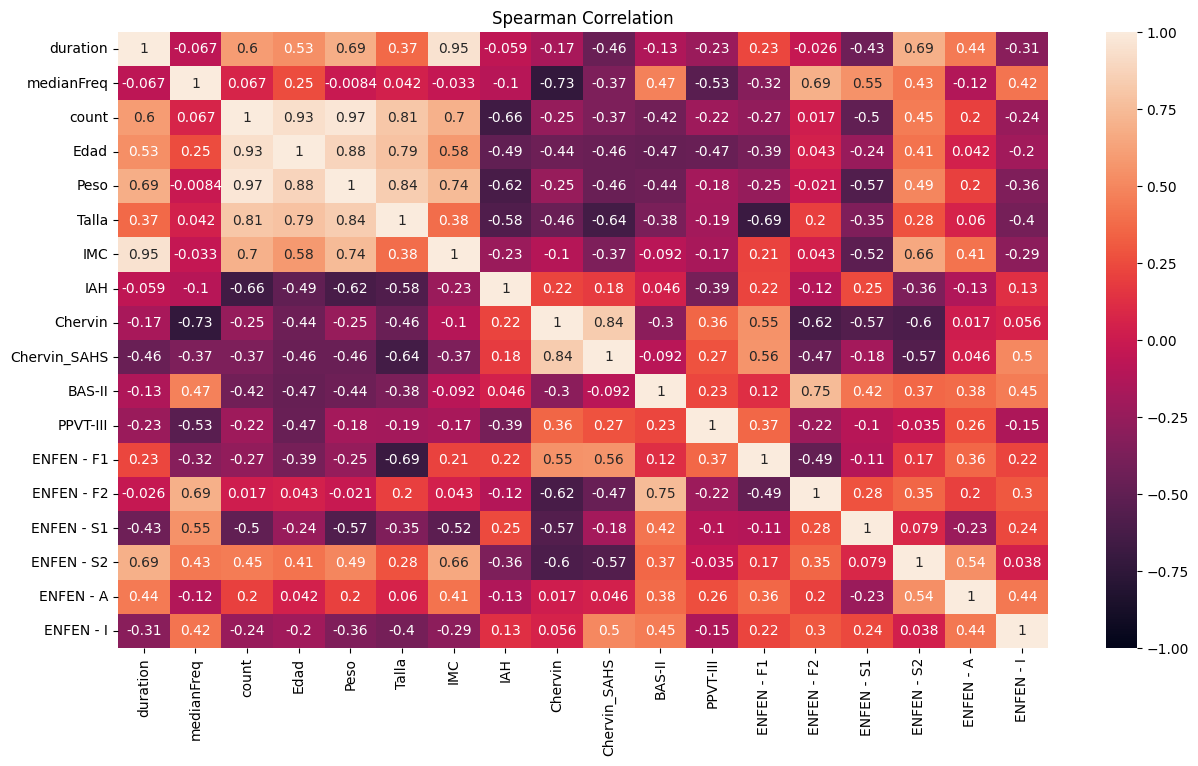

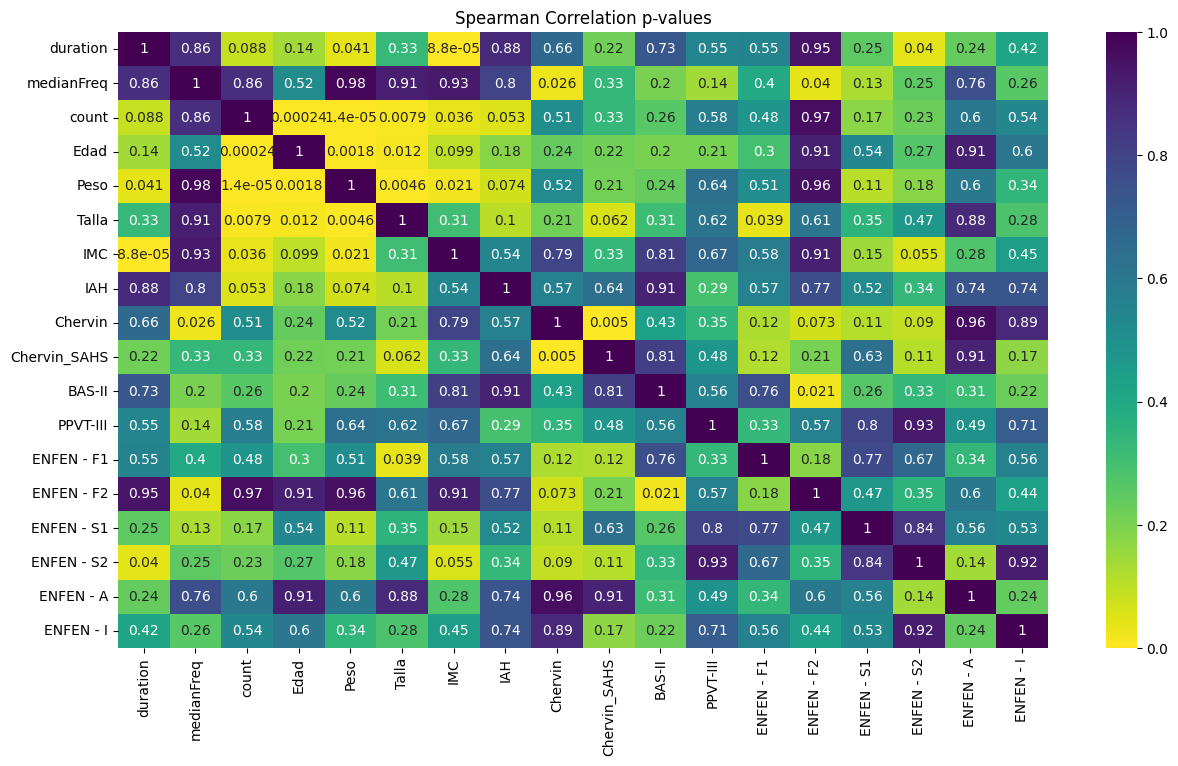

In [113]:
#correlation matrices
from scipy.stats import spearmanr
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

def spearmanr_r(x,y):
        return spearmanr(x,y)[0]

r=descriptors.corr(method=spearmanr_r)
pval=descriptors.corr(method=spearmanr_pval)

import seaborn as sns # For pairplots and heatmaps
plt.figure(figsize=(15,8))
heatmap = sns.heatmap(r, vmin=-1, vmax=1, annot=True)
plt.title("Spearman Correlation")

plt.figure(figsize=(15,8))
heatmap = sns.heatmap(pval, vmin=0, vmax=1, annot=True,cmap=plt.cm.get_cmap('viridis_r'))
plt.title("Spearman Correlation p-values")

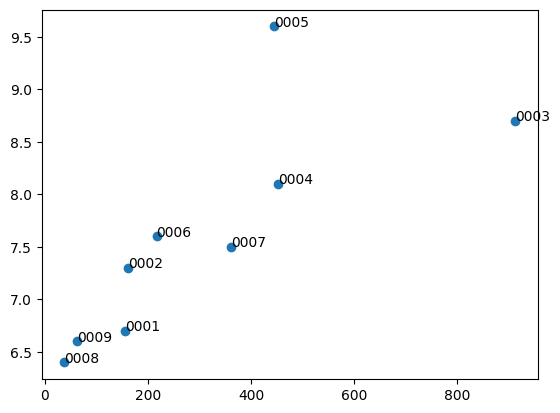

In [130]:
plt.plot(descriptors['count'],descriptors['Edad'],linestyle='',marker='o')
for x,y,text in zip(descriptors['count'],descriptors['Edad'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

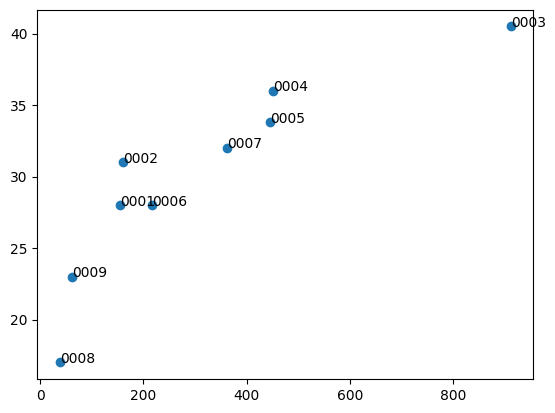

In [131]:
plt.plot(descriptors['count'],descriptors['Peso'],linestyle='',marker='o')
for x,y,text in zip(descriptors['count'],descriptors['Peso'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

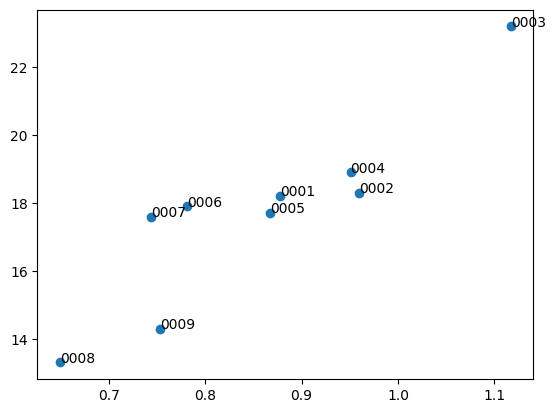

In [132]:
plt.plot(descriptors['duration'],descriptors['IMC'],linestyle='',marker='o')
for x,y,text in zip(descriptors['duration'],descriptors['IMC'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

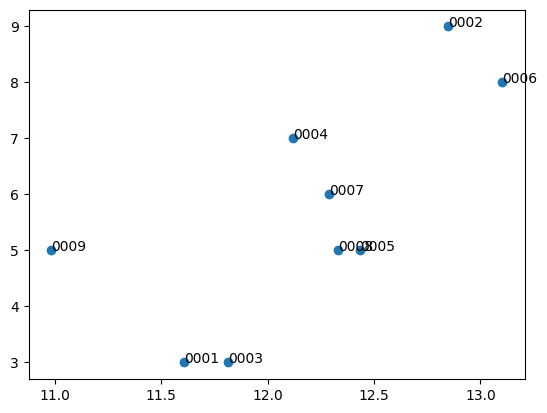

In [134]:
plt.plot(descriptors['medianFreq'],descriptors['ENFEN - F2'],linestyle='',marker='o')
for x,y,text in zip(descriptors['medianFreq'],descriptors['ENFEN - F2'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

In [ ]:
plt.plot(descriptors['medianFreq'],descriptors['Chervin'],linestyle='',marker='o')
for x,y,text in zip(descriptors['medianFreq'],descriptors['Chervin'],descriptors['subjectId']):
    plt.annotate(text,(x,y))